![](q_learning.png)

$$
    (1 - \alpha) \cdot Q(S, A) + \alpha \ ( R + \gamma  \underset{a}{\max} Q(S', a))
$$

In [403]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output

import matplotlib.pyplot as plt
from collections import deque
import random

from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import NotFittedError

import numpy as np

import gym
from gym.spaces import Discrete

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

GYM_NAME = 'MountainCar-v0'
ENV = gym.make(GYM_NAME)

EPISODES = 500
ALPHA = 0.7
GAMMA = 0.95
EPSILON = 0.1
TRAINING_SIZE = 1_000


if GYM_NAME == 'CartPole-v0':
    EPISODES = 500
    ALPHA = 0.7
    GAMMA = 0.95
    EPSILON = 0.1
    TRAINING_SIZE = 5000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class EnviromentRunner:
    """Class used to run the enviroment and cache experience."""
    
    
    def __init__(
        self,
        memory_size=100_000,
        env=ENV,
        gym_name=GYM_NAME,
    ):
        
        self.memory_size = memory_size
        self.env = env    
        self.gym_name = gym_name
        
        self.experience = deque(maxlen=memory_size)
    
    
    def reward(self, state, action, new_reward, new_state, done, info):
        """Used to customize the reward function for a given gym."""
        
        if GYM_NAME == 'CartPole-v0':
            return -1 if done else new_reward
        
        elif GYM_NAME == 'MountainCar-v0':
            return new_state[0] + 0.5
        
        return new_reward
    

    def run(self, policy=None, verbose=0, exhibition=False):
        """Used to generate an episode."""

        # Start the enviroment an log the start state.
        state = self.env.reset()
        
        episode_length = 0
        total_reward = 0
        
        try:

            while True:

                if exhibition:
                    self.env.render()

                if policy is None:
                    action = self.env.action_space.sample()
                else: 
                    action = policy(state)

                new_state, new_reward, done, info = self.env.step(action) 

                # Recalculate reward.
                new_reward = self.reward(state, action, new_reward, new_state, done, info)

                # Save SARS
                self.experience.append(
                    (state, action, new_reward, new_state)
                )

                if verbose >= 2:
                    print(
                        f"\nepisode length: {episode_length}\n"
                        f"state: {state}\n"
                        f"action: {action} "
                        f"new_reward: {new_reward}\n"
                        f"new_state: {new_state}\n"
                    )


                # Current state is now the new state.
                state = new_state

                # For monitoring.
                episode_length += 1
                total_reward = total_reward + new_reward

                if done and not exhibition:
                    break
                

        finally: 
            
            self.env.close()
        
        if verbose >= 1:
            print(
                f"\ntotal episode length: {episode_length} "
                f"total reward: {total_reward} "
            )
        
        return episode_length, total_reward

        
enviroment_runner = EnviromentRunner()
enviroment_runner.run()
assert len(enviroment_runner.experience) > 0

In [400]:
class ActionValueApproximator:
    """A class which approximates the action value function."""
    
    
    def __init__(
        self, 
        env=ENV,
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,
        training_size=TRAINING_SIZE,
        X_pipeline = StandardScaler(),
        y_pipeline = StandardScaler(),
    ):

        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.training_size = training_size
        self.X_pipeline = X_pipeline
        self.y_pipeline = y_pipeline

        
        if isinstance(env.action_space, Discrete):
            self.input_dim = env.observation_space.shape[0] + 1
        else:
            self.input_dim = env.observation_space.shape[0] + env.action_space.shape[0]
        
        
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=self.input_dim, activation='relu'))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(1, activation='relu'))
        self.model.add(Activation('linear'))
        self.model.compile(
            optimizer=Adam(lr=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )
        
    
    def fit(self, X, y, fit_kwargs={
        'batch_size': 32, 
        'epochs': 10,
        'use_multiprocessing': True,
    }):
        """Train value approximator."""
        
        print('\nTrain...')
        # print(f"\nX:\n {X}\ny:\n {y}, total ys != alpha: {np.sum(y != self.alpha)}")
        # X = self.X_pipeline.fit_transform(X)
        # y = self.y_pipeline.fit_transform(y)
        self.model.fit(X, y, **fit_kwargs)
        return self
    
    
    def predict(self, X):
        """Predict based on preprocessed X."""
        try:
            # X = self.X_pipeline.transform(X)
            return self.model.predict(X)
        except NotFittedError:
            return np.random.randn(1, 1)
    
    
    def replay(self, experience):
        """Fit based on cached experience."""
        
        if len(experience) < self.training_size:
            return self
        
        Xs = []
        ys = []
        
        subsample = random.sample(experience, self.training_size)
        
        for sars in subsample:
            Xs.append(self.get_X(*sars))
            ys.append(self.get_y(*sars))
        
        X = np.concatenate(Xs)
        y = np.concatenate(ys)
        
        self.fit(X, y)
        return self

            
    def get_X(self, state, action, *args):
        """Get input."""
        return np.concatenate((state, np.array([action]))).reshape(1, -1)
    
    
    def get_y(self, state, action, new_reward, new_state):
        """Get the target value."""
        value_update = (
            new_reward + self.gamma * max(
                self.value(new_state, action)
                for action in range(self.env.action_space.n)
            )
        )
        return (1 - self.alpha) * self.value(state, action) + self.alpha * value_update 

    
    def value(self, state, action, *args):
        """The value of taking an action in a given state."""
        X = self.get_X(state, action)
        return k
    
    
    def policy(self, state):
        """Epsilon greedy policy using the value approximation."""
        
        # With probability `epsilon` take a random action.
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        
        # Best action.
        return np.argmax([
            self.value(state, action)
            for action in range(self.env.action_space.n)
        ])
    

In [385]:
value_approximator.get_y(*enviroment_runner.experience[3])

array([[-0.04558911]], dtype=float32)

# Run the model

You can break the cell whenever.

In [401]:
enviroment_runner = EnviromentRunner()
value_approximator = ActionValueApproximator()
runner_log = []


In [412]:

for episode in range(EPISODES):
    
    print(f"\n--- EPISODE {episode} ---")
    
    episode_length, total_reward = enviroment_runner.run(
        policy=value_approximator.policy,
        verbose=1
    )
    runner_log.append({'episode_length': episode_length, 'total_reward': total_reward})
    
    value_approximator.replay(
        enviroment_runner.experience
    )
    


--- EPISODE 0 ---

total episode length: 200 total reward: 23.464054579671366 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0032 - mae: 0.0312 - mse: 0.0032
Epoch 2/10
1000/1000 [==============================] - 0s 81us/step - loss: 0.0055 - mae: 0.0312 - mse: 0.0055
Epoch 3/10
1000/1000 [==============================] - 0s 78us/step - loss: 0.0393 - mae: 0.0870 - mse: 0.0393
Epoch 4/10
1000/1000 [==============================] - 0s 80us/step - loss: 0.0994 - mae: 0.1575 - mse: 0.0994
Epoch 5/10
1000/1000 [==============================] - 0s 78us/step - loss: 0.0414 - mae: 0.0907 - mse: 0.0414
Epoch 6/10
1000/1000 [==============================] - 0s 74us/step - loss: 0.0202 - mae: 0.0882 - mse: 0.0202
Epoch 7/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0057 - mae: 0.0402 - mse: 0.0057
Epoch 8/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0025 - mae: 0.0271 - mse: 0.0025
Epoch 9/10
100

KeyboardInterrupt: 

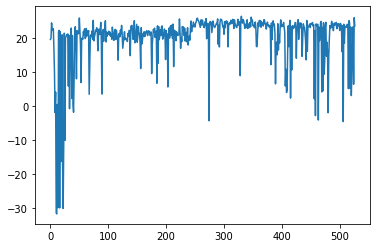

In [413]:
total_rewards = np.array(list(map(lambda log: log['total_reward'], runner_log)))
plt.plot(total_rewards)

In [414]:
value_approximator.epsilon = 0.0
enviroment_runner.run(
    policy=value_approximator.policy,
    exhibition=True,
    verbose=True
)

KeyboardInterrupt: 